### New file

In [2]:
%matplotlib inline

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os

In [3]:
distros = ['mix', 'gau 1', 'gau 2', 'exp']
stepsizes = ['const', '2/sqrt_k', '0.002/sqrt_k']

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

N_q = len(tau_vals)

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [4]:
def get_settings(distro_lst, datasize_lst, stepsize_lst):
    len_lst = [len(distro_lst), len(datasize_lst), len(stepsize_lst)]
    if len_lst.count(1) != len(len_lst)-1: raise Exception("Setting inputs are wrong!")
    
    N_settings = max((len_lst))
    setting_lst = []
    for lst in [distro_lst, datasize_lst, stepsize_lst]:
        if len(lst)==1: 
            lst = lst*N_settings
        setting_lst.append(lst)
    return np.asarray(setting_lst).T, len(stepsize_lst)>1


In [5]:
def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau 1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau 2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)
    else: raise Exception("distribution doesn't work!")

In [6]:
def get_dataset(distro, datasize, g_test=False):
    if g_test:
        dataset = np.zeros((N_g, datasize))
        for i in range(N_g):
            dataset[i] = get_one_dt(distro, datasize)
    else:
        dataset = get_one_dt(distro, datasize)
    return dataset

In [7]:
def get_q_true(distro, tau_lst):
    if tau_lst == tau_vals:
        if distro=='gau 1':
            return np.asarray([-21.06792817980280840537, 
                              -7.43920922874473411269,
                              2,
                              25.06792817980280840537,
                              43.87426173273513981594])
        elif distro=='gau 2':
            return np.asarray([-0.001281551565544600466965,
                              -5.244005127080407840383E-4,
                              0,
                              0.001281551565544600466965,
                              0.002326347874040841100886])
        elif distro=='mix':
            # sampled from 100000000 datapoints
            return np.asarray([-80.28496182,
                               -29.02324254,
                               -0.36011575,
                               36.69268923,
                               120.7676231])
        elif distro=='exp':
            return np.asarray([0.1053605156578263012275,
                              0.3566749439387323789126,
                              0.6931471805599453094172,
                              2.302585092994045684018,
                              4.605170185988091368036])
    raise Exception('tau_lst should be tau_vals')
    

In [8]:
def get_q_batch(dataset, tau_lst):
    if len(dataset.shape) != 1:
        raise Exception('Dataset for q_batch calculation of wrong shape: ' + str(dataset.shape))
        
    q_batch = np.zeros(len(tau_lst))
    for i, tau in enumerate(tau_lst):
        q_batch[i] = np.percentile(dataset, tau*100)
    return q_batch

In [9]:
def get_q_batches(dataset, tau_lst):
    # g_test = False
    if len(dataset.shape) == 1: 
        return get_q_batch(dataset, tau_lst)
    else:
        q_batches = np.zeros((dataset.shape[0], len(tau_lst)))
        for i in range(q_batches.shape[0]):
            q_batches[i] = get_q_batch(dataset[i], tau_lst)
    return q_batches

In [10]:
def set_stepsize(k, stepsize):
    if stepsize=='const':
        return 1
    elif stepsize=='2/sqrt_k':
        return 2/math.sqrt(k)
    elif stepsize=='0.002/sqrt_k':
        return 0.002/math.sqrt(k)
    raise Exception('stepsize parameter is wrong')

In [11]:
def get_procs(dataset, step_size, tau_lst):
    if len(dataset.shape)!= 1: 
        raise Exception('Dataset for get_procs() of wrong shape:' + str(dataset.shape)+ ', should be 1d array')
        
    procs = np.zeros((len(tau_lst), dataset.shape[0]))
    for idx, tau in enumerate(tau_lst):
        q = 0
        q_sgd_proc = procs[idx]
        # change stepsize
        if step_size != 'frugal':
            for k, x in enumerate(dataset):
#                 if idx==1: print (k, ':', q)
                alpha = set_stepsize(k+1, step_size)
                if x > q:
                    q = q + alpha*tau
                else:
                    q = q - alpha*(1-tau)
                q_sgd_proc[k] = q
        
        # frugal
        else:
            rdn_lst = np.random.uniform(0,1, dataset.shape[0])
            for k, x in enumerate(dataset):
                rdn = rdn_lst[k]
                if x > q and rdn > 1-tau:
                    q += 1
                elif x < q and rdn > tau:
                    q -= 1
                q_sgd_proc[k] = q
    return procs

In [12]:
# dataset = np.random.uniform(-100, 100, 1000)
# proc = get_procs(dataset, 'const', tau_vals)
# # print(proc[1])
# plt.plot(proc.T)

In [13]:
def get_res(procs):
    if len(procs.shape)!=2:raise Exception('Procs of wrong shape:' + str(procs.shape)+ ', should be 2d array')
    return procs[:, -1]

In [14]:
def get_q_ests(dataset, step_size, tau_lst):

    if len(dataset.shape)>2:
        raise Exception('Dataset for q_est calculation of wrong shape:' + str(dataset.shape)+ ', should be 1d or 2d array')
    if len(dataset.shape)==1:
        procs = get_procs(dataset, step_size, tau_lst)
        res = get_res(procs)
    else:
        res = np.zeros((dataset.shape[0], len(tau_lst)))
        procs = np.zeros((dataset.shape[0], len(tau_lst), dataset.shape[1]))
        for idx, dt in enumerate(dataset):
            procs[idx] = get_procs(dt, step_size, tau_lst)
            res[idx] = get_res(procs[idx])
    return res, procs

In [15]:
# dataset = get_dataset('gau 1', 1000, g_test=True) * 50 - 200
# print(dataset.shape)

# # proc1 = get_procs(dataset, 'const', tau_vals)
# ## res1 = get_res(proc1)
# # proc2 = get_procs(dataset, 'frugal', tau_vals)
# # plt.plot(proc1.T)ad
# # plt.plot(proc2.T)
# # plt.show()


# res, proc = get_q_ests(dataset, 'const', tau_vals)
# print(res)
# print(proc)

In [16]:
def get_normalized_e(true, batches, est):
    upper = est - batches
    bottom = true - batches
    return abs(upper/bottom)

### Plots

In [17]:
def naming(distro, datasize, stepsize, tau_list, g_test, s_test):
    return [1, 2, 3]
#     return 3 differnt names?

In [18]:
dataset = get_dataset('mix', 1000, True)
q_batches = get_q_batches(dataset, tau_vals)
q_true = get_q_true('mix', tau_vals)
sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_vals)
print (sgd_proc[3])

[[  0.1   -0.8   -1.7  ... -76.2  -76.1  -76.  ]
 [  0.3   -0.4   -1.1  ... -12.6  -12.3  -12.  ]
 [  0.5    0.    -0.5  ...   0.     0.5    0.  ]
 [  0.9    0.8    0.7  ...  38.2   38.1   38.  ]
 [  0.99   0.98   0.97 ...  71.02  71.01  71.  ]]


In [19]:
def plot_one_proc(tau_lst, q_proc, ax, label_on):
    for idx, q in enumerate(q_proc):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+'-quantile' if label_on else ''
        ax.plot(q, color=colorVal, label=lb)  

# fig, ax = plt.subplots(1,1)
# plot_one_proc(tau_vals, sgd_proc, ax, True)

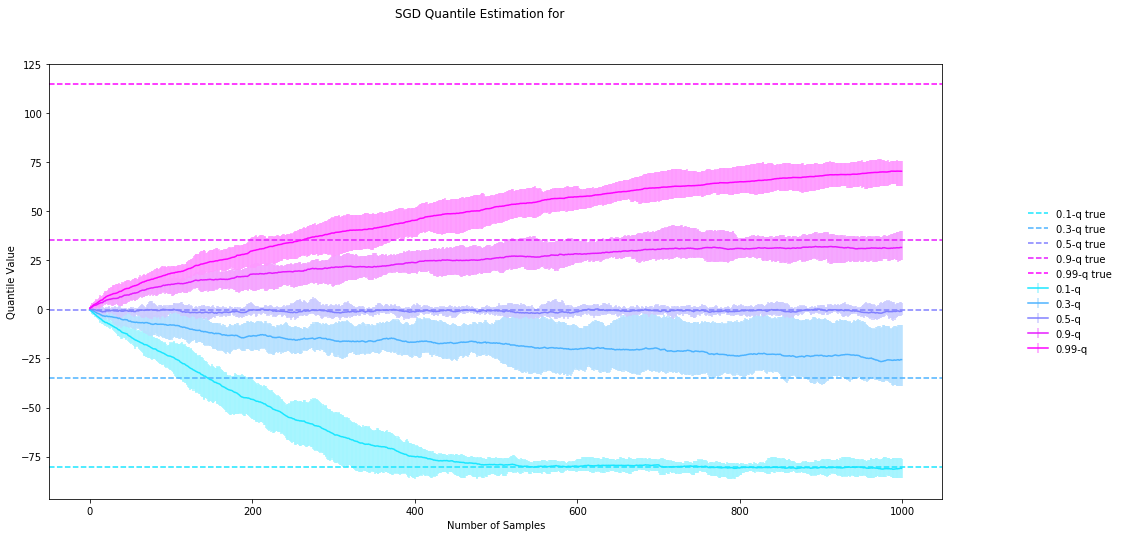

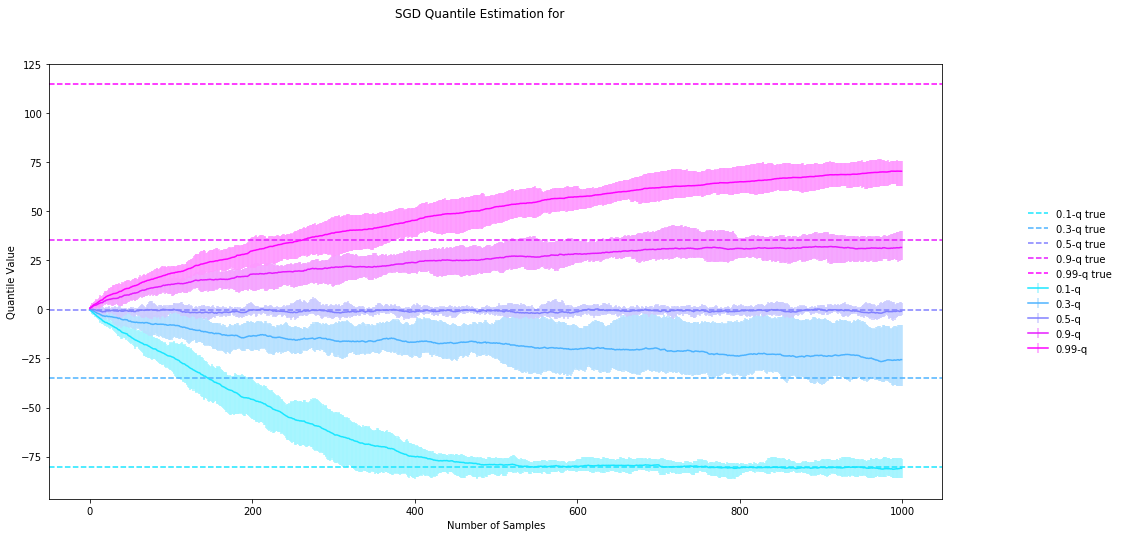

In [66]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
#     import matplotlib.colors as mc
    import colorsys
    try:
        c = colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_procs_error_bar(ax, tau_lst, q_true, q_procs, Frugal):
    N_dim = len(q_procs.shape)

    if q_true is not None:
        if len(q_true.shape)==2: q_true = q_true.mean(axis=0)
        for idx, q in enumerate(q_true):
            colorVal = scalarMap.to_rgba(tau_lst[idx])                
            ax.axhline(q, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
    if N_dim == 2:
        plot_one_proc(tau_lst, q_procs, ax, True)
            
    elif N_dim == 3: 
        proc_mean = np.mean(q_procs, 0)
        proc_max = np.max(q_procs, 0) - proc_mean
        proc_min = proc_mean - np.min(q_procs, 0) 
        
        for i in range(len(tau_lst)):
            
            err = np.vstack((proc_max[i], proc_min[i]))
            colorVal = scalarMap.to_rgba(tau_lst[i])
            ax.errorbar(np.arange(proc_mean.shape[-1]),
                        proc_mean[i], 
                        yerr=err, ecolor = lighten_color(colorVal, 0.4),
                        color=colorVal, 
                        label = str(tau_lst[i])+'-q'+('Frugal' if Frugal else ''))


    ax.set_xlabel('Number of Samples')
    if (q_true is not None):
        ax.set_ylabel('Quantile Value')  
    else: ax.set_ylabel('Error Value')
    

def plot_procs(tau_lst, q_true, q_procs, q_compare=None):
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('SGD Quantile Estimation for ')
    ax = fig.add_subplot(111)
    

    plot_procs_error_bar(ax, tau_lst, q_true, q_procs, (q_compare is not None))
    
    if q_compare is not None:
        for idx, proc in enumerate(q_compare):
            colorVal = scalarMap.to_rgba(tau_lst[idx])
            ax.plot(proc, color = lighten_color(colorVal, 1.6),
                   label = str(tau_lst[idx])+'-q SGD')
    
    ax.legend(loc='right', bbox_to_anchor=(1.2, 0.5),
    frameon=False, ncol=(1 if q_compare is None else 2))
    
    return fig


_, compare_proc = get_q_ests(dataset, '2/sqrt_k', tau_vals)

plot_procs(tau_vals, q_batches, sgd_proc)

In [41]:
def plot_charts(folder_name, q_lst, q_batches, q_sgd_res, proc_filename, proc_shape):
    
    print ("compare results with stripe plots")
    stripes = plot_spectrum_stripes(q_lst, q_batches, q_sgd_res)
    plt.savefig( folder_name+"res_stripes.png")
    
    print ("compare processes with error bars")
    q_procs = np.memmap(proc_filename, np.float32, 'r+', shape=proc_shape)
    errbars = plot_procs_error_bar(q_lst, q_batches, q_procs)
    plt.savefig(folder_name+"proc_errbars.png")
    
    print ("compare E results")
    e = compute_E_res(q_lst, q_batches, q_sgd_res)
    errs = plot_E_res(q_lst, e)
    plt.savefig(folder_name+"e_stripes.png")
    
#     return plts
    return 4

### Main functions 

In [25]:
def quantile_sgd_compare(distro_lst, datasize_lst, stepsize_lst, 
                         g_test=False, s_test=False, tau_lst=tau_vals, 
                        chart_lst = []):
    
    if g_test and s_test: raise Exception("g_test and s_test can't both be true")
    
    # generate different settings
    setting_lst, is_stepsize = get_settings(distro_lst, datasize_lst, stepsize_lst,)
    print (setting_lst)
    # if only stepsize changes, generate dataset and q_batches
    dataset, q_batches = 0, 0
    if is_stepsize:
        dataset = get_dataset(distro_lst[0], datasize_lst[0], g_test)
        q_batches = get_q_batches(dataset, tau_lst)
        
    # for each setting = [distro, datasize, stepsize]
    for idx, setting in enumerate(setting_lst):
        # generate all the data
        distro, datasize, stepsize = setting[0], int(setting[1]), setting[2]
        q_true = get_q_true(distro, tau_lst)
        if not is_stepsize:
            dataset = get_dataset(distro, datasize, g_test)
            q_batches = get_q_batches(dataset, tau_lst)
        if s_test:
            shuffled_dt = np.zeros((N_s, datasize))
            for i in range(N_s):
                np.random.shuffle(dataset)
                shuffled_dt[i] = dataset
            dataset = shuffled_dt
        q_est_res, q_est_proc = get_q_ests(dataset, stepsize, tau_lst)
        E = get_normalized_e(q_true, q_batches, q_est_res)
        print(E)
        
#         # generate charts and tables?
        name = naming(distro, datasize, stepsize, tau_lst, g_test, s_test)

#         charts = get_charts(folder_name, tau_lst, q_batches, q_sgd_res, q_sgd_proc, name)
# #         tables = get_tables(tau_lst, q_batches, q_sgd_res, q_sgd_proc, name)

In [26]:
def all_sgd_comparisons():
    topics = ['Frugal','Dataset', 'Step_size', 'Shuffle']
    for t in topics:
        folder_name = "Experiment_results/"+t+"/"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        if t=='Frugal':
            sgd_frugal_compare(folder_name, distros, 1000, tau_vals)
#         if t=='Dataset':
            

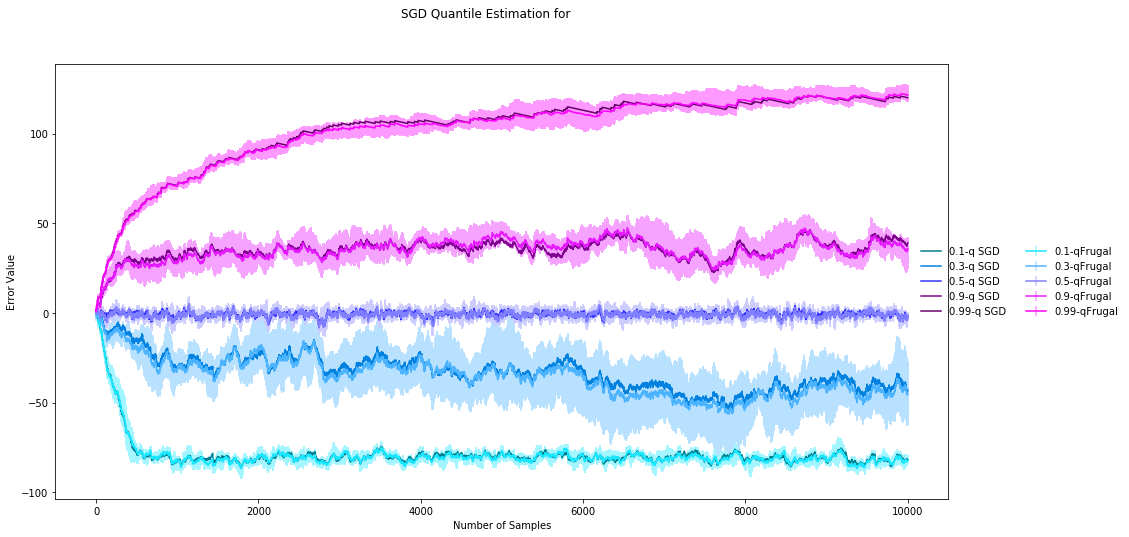

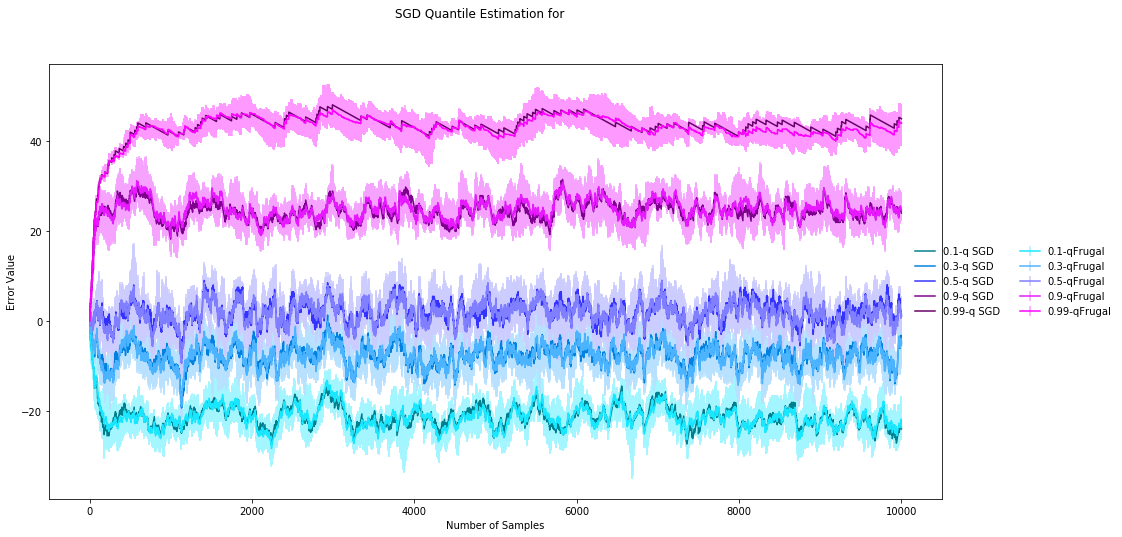

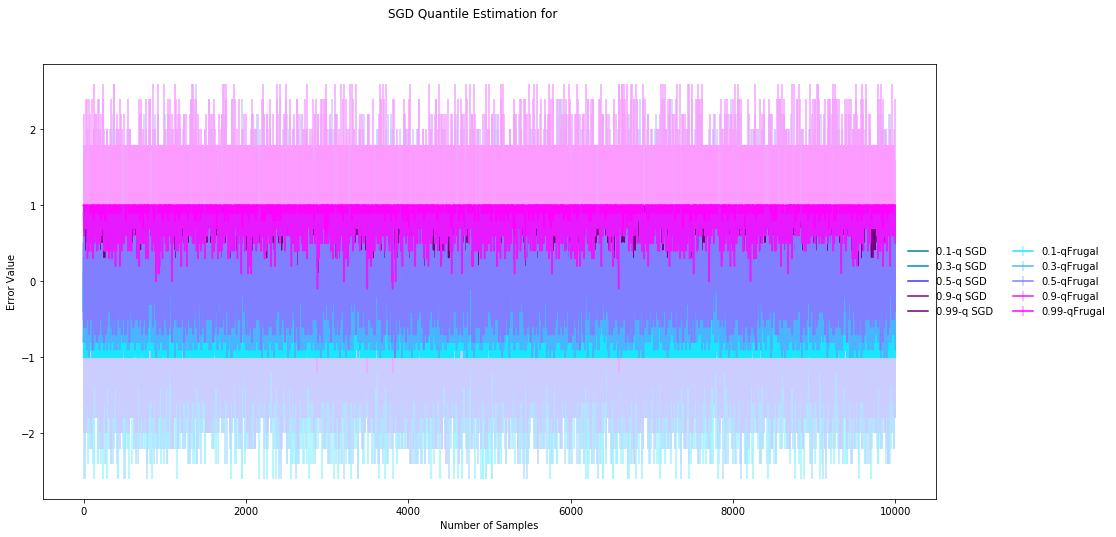

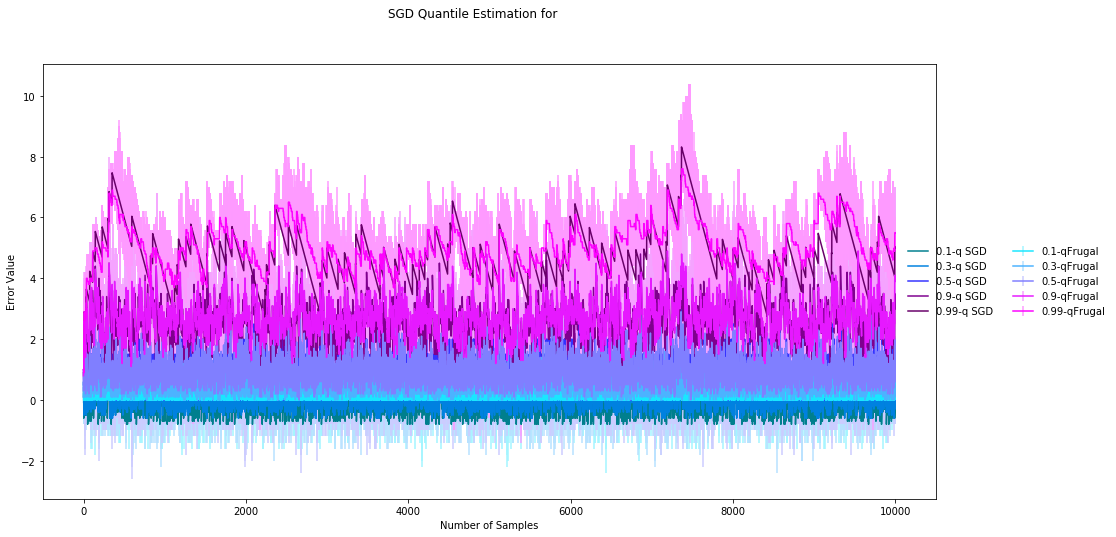

In [67]:
def sgd_frugal_compare(distro_lst, datasize, tau_lst=tau_vals):
    #distro changes, use the biggest datasize, do not shuffle
    for distro in distro_lst:
        dataset = get_dataset(distro, datasize, False)
        q_batches = get_q_batches(dataset, tau_lst)
        
        sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_lst)
        
        N_frugal = 10
        frugal_res = np.zeros((N_frugal, len(tau_lst)))
        frugal_proc = np.zeros((N_frugal, len(tau_lst), datasize))
        for i in range(N_frugal):
            frugal_res[i], frugal_proc[i] = get_q_ests(dataset, 'frugal', tau_lst)
            
        plot_procs(tau_vals, None, frugal_proc, sgd_proc)

        
sgd_frugal_compare(distros, 10000)

In [29]:
# all_sgd_comparisons()

<!---
### Always have $q_k = x$ for each x in the data stream

When $x - q_k > 0$, we have $l(q_k) = \tau(x-q_k)$:
\begin{align}
q_{k+1} & = q_k - \frac{l(q_k)}{l'(q_k)} \\
        & = q_k - \frac{\tau(x-q_k)}{-\tau} \\
        & = q_k - (- x + q_k) \\
        & = x
\end{align}

Same happens when $x - q_k < 0$
-->

In [31]:
quantile_sgd_compare(distro_lst=['mix'], 
                     datasize_lst=[10, 100, 1000], 
                     stepsize_lst=['const'], 
                     g_test=False,
                     s_test=False)

[['mix' '10' 'const']
 ['mix' '100' 'const']
 ['mix' '1000' 'const']]
[[-0.9  -0.8  -1.7  -1.6  -1.5  -1.4  -2.3  -3.2  -4.1  -4.  ]
 [-3.7  -3.4  -4.1  -3.8  -3.5  -3.2  -3.9  -4.6  -5.3  -5.  ]
 [-4.5  -4.   -4.5  -4.   -3.5  -3.   -3.5  -4.   -4.5  -4.  ]
 [-3.1  -2.2  -2.3  -1.4  -0.5   0.4   0.3   0.2   0.1   1.  ]
 [ 0.99  1.98  1.97  1.96  2.95  3.94  3.93  3.92  3.91  4.9 ]]
[ 7.12263407 13.02812974  1.55744653  1.41218275  5.9708147 ]


UnboundLocalError: local variable 'i' referenced before assignment